# Make your own `ImagePipeline`

For a more detailed explanation on the components of `phenotypic.Image` and `phenotypic.GridImage`, see the {doc} `Images` and {doc} `GridImages` tutorial.

This tutorial demonstrates how to build and use image processing pipelines in PhenoTypic for automated analysis of arrayed microbial colonies on agar plates. It also discusses some of the caveats with the different steps


(<Figure size 800x600 with 1 Axes>, <Axes: >)

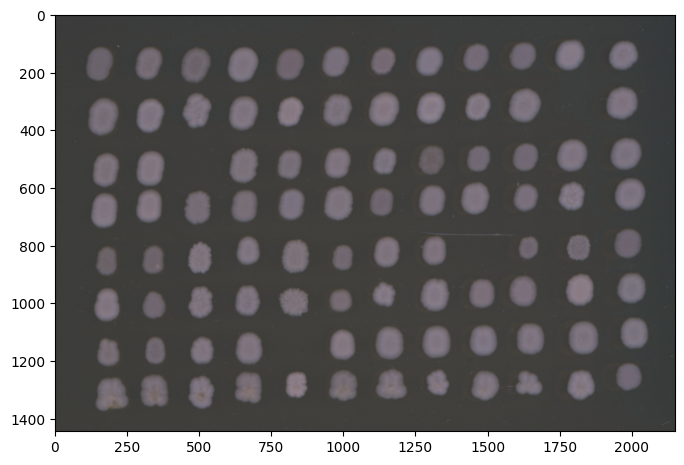

In [1]:
import phenotypic as pht

plate_image = pht.GridImage(pht.data.load_plate_72hr())
plate_image.show()


## Preprocessing Layer

(<Figure size 1000x500 with 2 Axes>,
 array([(<Figure size 1000x500 with 2 Axes>, <Axes: title={'center': '334389be-57c6-4b3d-ae7e-652b4e119dce'}>),
        <Axes: >], dtype=object))

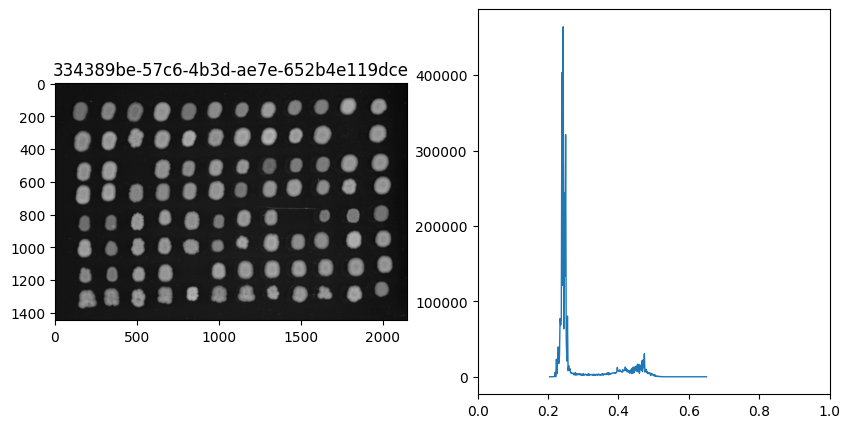

In [2]:
plate_image.enh_gray.histogram()


From the histogram, we can see that the contrast is not being maximized, since the minimum value is at 0.2 and the highest value is around 6.5. The full range of grayscale values is from 0-1. Many detection algorithms rely on a bimodal distribution of intensity to separate the foreground and background. Thus, we should enhance the contrast to improve detection.

In [3]:
from phenotypic.enhance import GaussianBlur

blur = GaussianBlur()
blur.widget(plate_image)


In [4]:
from phenotypic import ImagePipeline
from phenotypic.enhance import CLAHE, GaussianBlur, MedianEnhancer, ContrastStretching
from phenotypic.detect import WatershedDetector
from phenotypic.correction import GridAligner
from phenotypic.grid import GridApply, MinResidualErrorReducer, GridAlignmentOutlierRemover
from phenotypic.refine import BorderObjectRemover, SmallObjectRemover, LowCircularityRemover
from phenotypic.refine import MaskFill

from phenotypic.measure import MeasureColor, MeasureShape, MeasureIntensity, MeasureTexture

kmarx_pipeline = ImagePipeline(
        ops={
            'blur'                            : GaussianBlur(sigma=5),
            'clahe'                           : CLAHE(),
            'median filter'                   : MedianEnhancer(),
            'detection'                       : WatershedDetector(footprint='auto', min_size=50, relabel=True),
            'mask_fill'                       : MaskFill(),
            'RemoveBorderObjects'             : BorderObjectRemover(),
            'low circularity remover'         : LowCircularityRemover(0.7),
            'reduce by section residual error': MinResidualErrorReducer(),
            'outlier removal'                 : GridAlignmentOutlierRemover(),
            'align'                           : GridAligner(),
            'grid_reduction'                  : MinResidualErrorReducer(),
        },
        meas={
            'MeasureColor'    : MeasureColor(),
            'MeasureShape'    : MeasureShape(),
            'MeasureIntensity': MeasureIntensity(),
            'MeasureTexture'  : MeasureTexture(scale=3),
            'MeasureTexture2' : MeasureTexture(scale=4),
        }
)
kmarx_pipeline.widget()


In [ ]:

pipeline_output = kmarx_pipeline.apply(plate_image)
pipeline_output.objects.relabel()
pipeline_output.show_overlay()


(<Figure size 900x1000 with 1 Axes>, <Axes: >)

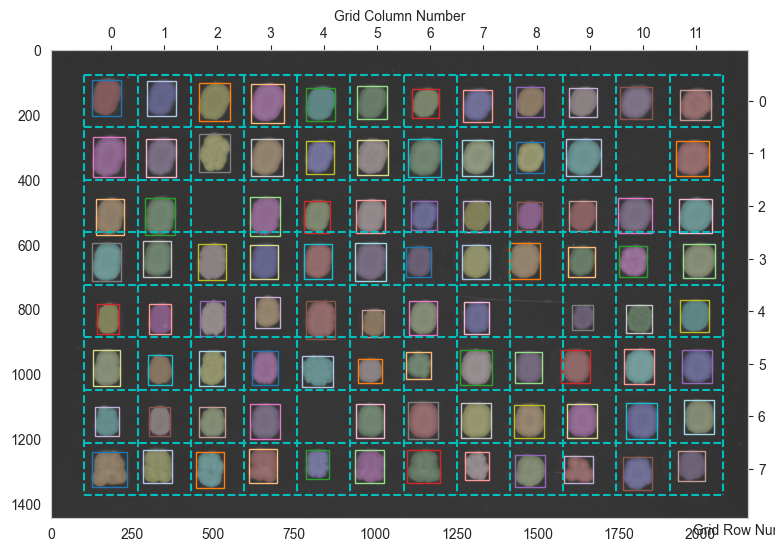

In [ ]:
from phenotypic.prefab import HeavyWatershedPipeline

pipeline_output2 = HeavyWatershedPipeline().apply(plate_image)
pipeline_output2.show_overlay()


(<Figure size 1000x500 with 2 Axes>,
 array([(<Figure size 1000x500 with 2 Axes>, <Axes: title={'center': '44fb607b-d11f-4d9e-b225-0f2b9b052746'}>),
        <Axes: >], dtype=object))

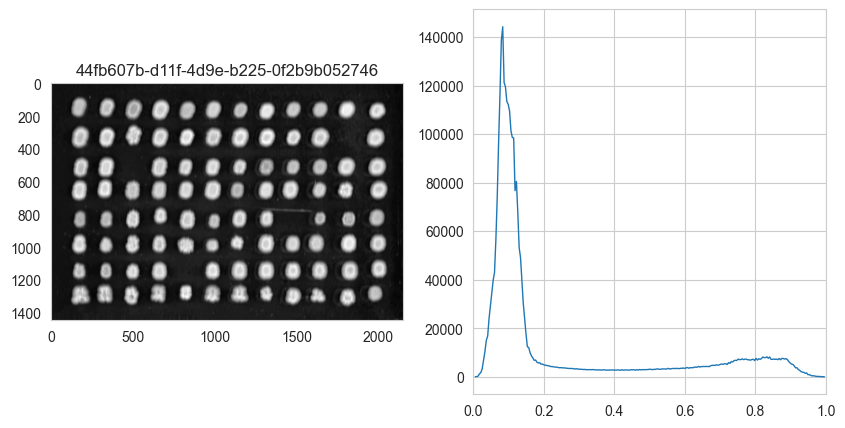

In [6]:
pipeline_output.enh_gray.histogram()


In [ ]:
pipeline_meas = kmarx_pipeline.measure(pipeline_output, include_metadata=False)
pipeline_meas


,ObjectLabel,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,Bbox_MaxCC,Grid_RowNum,Grid_ColNum,Grid_SectionNum,...,TextureGray_HaralickVariance-avg-scale04,TextureGray_InverseDifferenceMoment-avg-scale04,TextureGray_SumAverage-avg-scale04,TextureGray_SumVariance-avg-scale04,TextureGray_SumEntropy-avg-scale04,TextureGray_Entropy-avg-scale04,TextureGray_DiffVariance-avg-scale04,TextureGray_DiffEntropy-avg-scale04,TextureGray_InfoCorrelation1-avg-scale04,TextureGray_InfoCorrelation2-avg-scale04
0,1,146.506703,170.569699,91,128,204,216,0,0,0,...,0.227501,0.917104,23.561500,0.725170,1.245760,1.447084,0.044131,0.675382,-0.292161,0.617447
1,2,149.396380,340.542659,97,298,204,386,0,1,1,...,0.738942,0.779646,25.834356,2.456797,2.475868,2.975292,0.028841,1.102396,-0.263979,0.763785
2,3,160.823387,503.184827,103,456,218,552,0,2,2,...,0.491629,0.844037,24.416443,1.642722,2.198116,2.531479,0.035992,0.916609,-0.294202,0.753914
3,4,163.507507,667.136392,105,616,224,720,0,3,3,...,1.169566,0.787356,27.764862,4.112562,2.690033,3.187108,0.026823,1.193745,-0.348834,0.855079
4,5,162.581936,988.687380,112,945,214,1035,0,5,5,...,1.006358,0.829287,26.639336,3.560625,2.155954,2.585183,0.032185,1.086397,-0.390953,0.841887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,1293.937771,489.301356,1239,448,1349,532,7,2,86,...,1.108200,0.742637,27.649365,3.755580,2.774204,3.409272,0.024679,1.263264,-0.269797,0.802120
86,87,1284.021505,1311.323189,1239,1275,1328,1350,7,7,91,...,1.370031,0.729467,27.969614,4.622844,2.764216,3.452672,0.021514,1.404993,-0.260746,0.795513
87,88,1298.299929,1475.423016,1250,1430,1348,1523,7,8,92,...,1.242901,0.774189,27.577465,4.450449,2.823792,3.349485,0.026872,1.125120,-0.352028,0.868454
88,89,1296.660489,1624.861193,1252,1582,1335,1670,7,9,93,...,1.464127,0.724083,27.086165,5.091357,2.989982,3.669252,0.023581,1.321775,-0.301962,0.848755


(<Figure size 800x600 with 1 Axes>, <Axes: >)

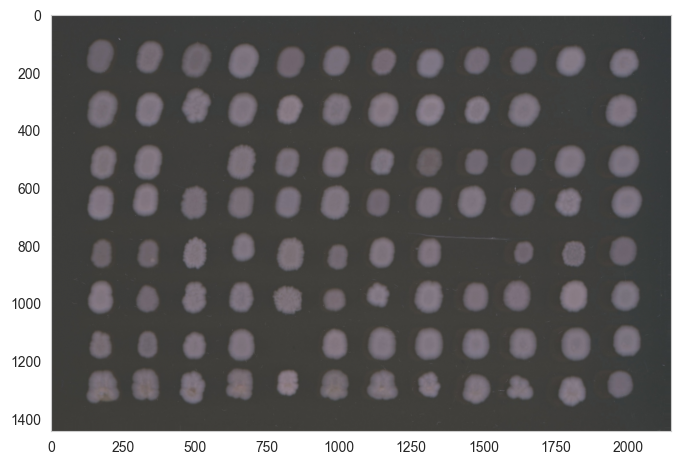

In [ ]:
pipeline_output.rgb.show()


min: 0.18000000715255737 max: 0.6553000211715698


<Axes: ylabel='Count'>

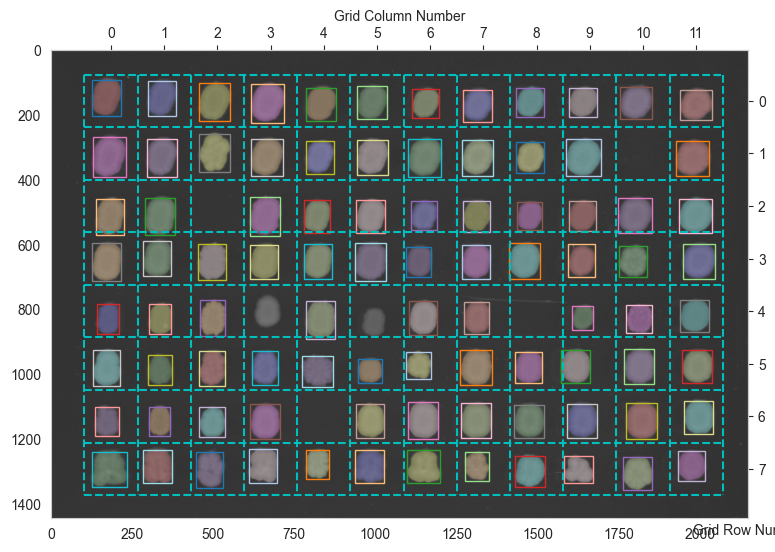

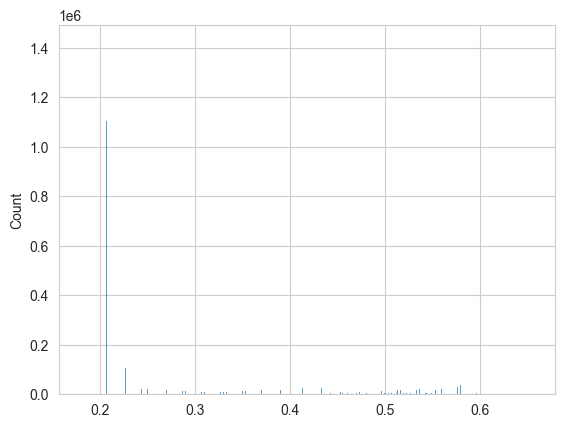

In [ ]:
fig, ax = pipeline_output.show_overlay()


(<Figure size 800x600 with 1 Axes>, <Axes: >)

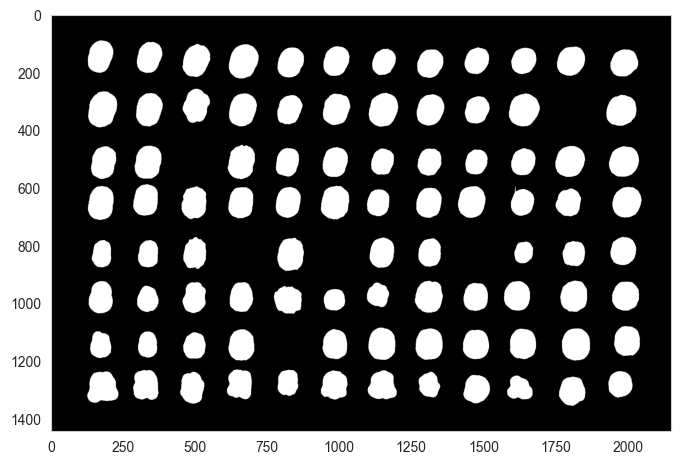

In [ ]:
pipeline_output.objmask.show()


In [13]:
pipeline_output.grid.info()


,Metadata_BitDepth,Metadata_ImageType,Metadata_ParentImageName,Metadata_ImageName,ObjectLabel,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,Bbox_MaxCC,Grid_RowNum,Grid_ColNum,Grid_SectionNum
0,8,GridImage,b'',44fb607b-d11f-4d9e-b225-0f2b9b052746,1,146.506703,170.569699,91,128,204,216,0,0,0
1,8,GridImage,b'',44fb607b-d11f-4d9e-b225-0f2b9b052746,2,149.396380,340.542659,97,298,204,386,0,1,1
2,8,GridImage,b'',44fb607b-d11f-4d9e-b225-0f2b9b052746,3,160.823387,503.184827,103,456,218,552,0,2,2
3,8,GridImage,b'',44fb607b-d11f-4d9e-b225-0f2b9b052746,4,163.507507,667.136392,105,616,224,720,0,3,3
4,8,GridImage,b'',44fb607b-d11f-4d9e-b225-0f2b9b052746,5,162.581936,988.687380,112,945,214,1035,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,8,GridImage,b'',44fb607b-d11f-4d9e-b225-0f2b9b052746,86,1293.937771,489.301356,1239,448,1349,532,7,2,86
86,8,GridImage,b'',44fb607b-d11f-4d9e-b225-0f2b9b052746,87,1284.021505,1311.323189,1239,1275,1328,1350,7,7,91
87,8,GridImage,b'',44fb607b-d11f-4d9e-b225-0f2b9b052746,88,1298.299929,1475.423016,1250,1430,1348,1523,7,8,92
88,8,GridImage,b'',44fb607b-d11f-4d9e-b225-0f2b9b052746,89,1296.660489,1624.861193,1252,1582,1335,1670,7,9,93


In [ ]:
shape_measurements = MeasureShape().measure(pipeline_output)
shape_measurements


,ObjectLabel,Shape_Area,Shape_Perimeter,Shape_Circularity,Shape_ConvexArea,Shape_MedianRadius,Shape_MeanRadius,Shape_MaxRadius,Shape_MinFeretDiameter,Shape_MaxFeretDiameter,Shape_Eccentricity,Shape_Solidity,Shape_Extent,Shape_BboxArea,Shape_MajorAxisLength,Shape_MinorAxisLength,Shape_Compactness,Shape_Orientation
0,1,7683.0,335.563492,0.857415,317.616082,14.142136,15.782705,41.048752,82.443454,112.946890,0.688207,24.189581,0.772627,9944.0,116.287931,84.368585,1.166296,-0.301111
1,2,7349.0,328.492424,0.855830,309.802847,13.928388,15.490497,40.718546,81.270536,110.208893,0.672004,23.721538,0.780480,9416.0,112.570343,83.363638,1.168457,-0.346249
2,3,8278.0,347.948268,0.859223,328.849209,14.764823,16.493031,43.863424,87.862531,116.468880,0.642563,25.172632,0.749819,11040.0,117.424997,89.974903,1.163842,-0.392919
3,4,9458.0,371.019336,0.863408,349.273610,16.000000,17.849295,48.010416,95.703709,122.114700,0.609198,27.079057,0.764221,12376.0,123.330059,97.802935,1.158201,-0.400819
4,5,7274.0,321.078210,0.886669,305.533007,14.000000,15.731636,42.059482,84.970583,107.540690,0.601665,23.807575,0.792375,9180.0,107.762019,86.074754,1.127817,-0.429974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,7151.0,328.492424,0.832772,309.230424,13.416408,14.925836,39.293765,80.445199,109.457754,0.672877,23.125150,0.773918,9240.0,111.295764,82.331500,1.200809,0.026111
86,87,4929.0,271.178716,0.842282,255.516412,11.180340,12.558015,34.000000,71.975989,88.566359,0.577093,19.290346,0.738427,6675.0,88.080214,71.933216,1.187251,0.189082
87,88,6995.0,317.078210,0.874309,299.816627,13.601471,15.440377,43.104524,87.467796,99.824847,0.440490,23.330928,0.767501,9114.0,99.870924,89.659878,1.143761,-0.365050
88,89,5396.0,294.592929,0.781335,273.725269,11.180340,12.340611,33.541020,79.881659,95.131488,0.497171,19.713196,0.738773,7304.0,90.984682,78.943092,1.279861,0.962156


In [ ]:
intensity_measurements = MeasureIntensity().measure(pipeline_output)
intensity_measurements


,ObjectLabel,Intensity_IntegratedIntensity,Intensity_MinimumIntensity,Intensity_MaximumIntensity,Intensity_MeanIntensity,Intensity_MedianIntensity,Intensity_StandardDeviationIntensity,Intensity_CoefficientVarianceIntensity,Intensity_LowerQuartileIntensity,Intensity_UpperQuartileIntensity,Intensity_InterquartileRangeIntensity
0,1,2958.221342,0.315973,0.447028,0.385035,0.393280,0.018061,0.046913,0.376440,0.398012,0.021572
1,2,3051.176300,0.320162,0.450094,0.415183,0.424600,0.027032,0.065118,0.400252,0.434407,0.034155
2,3,3272.532053,0.328571,0.435546,0.395329,0.398831,0.021133,0.053463,0.386255,0.412017,0.025762
3,4,4201.881607,0.312051,0.483713,0.444267,0.458502,0.035672,0.080303,0.428522,0.470267,0.041745
4,5,3086.875557,0.310102,0.457401,0.424371,0.442251,0.032696,0.077056,0.407827,0.448993,0.041165
...,...,...,...,...,...,...,...,...,...,...,...
85,86,3162.189429,0.327134,0.499667,0.442202,0.453435,0.033906,0.076686,0.421029,0.469702,0.048673
86,87,2198.213529,0.319291,0.508597,0.445976,0.458502,0.039786,0.089229,0.423514,0.476123,0.052609
87,88,3087.983356,0.334977,0.497153,0.441456,0.454581,0.035957,0.081463,0.415938,0.469955,0.054016
88,89,2332.659890,0.304446,0.489875,0.432294,0.445071,0.039725,0.091911,0.406375,0.465497,0.059122


In [ ]:
texture_measurements = MeasureTexture().measure(pipeline_output)
texture_measurements


,ObjectLabel,TextureGray_AngularSecondMoment-deg000-scale05,TextureGray_AngularSecondMoment-deg045-scale05,TextureGray_AngularSecondMoment-deg090-scale05,TextureGray_AngularSecondMoment-deg135-scale05,TextureGray_Contrast-deg000-scale05,TextureGray_Contrast-deg045-scale05,TextureGray_Contrast-deg090-scale05,TextureGray_Contrast-deg135-scale05,TextureGray_Correlation-deg000-scale05,...,TextureGray_HaralickVariance-avg-scale05,TextureGray_InverseDifferenceMoment-avg-scale05,TextureGray_SumAverage-avg-scale05,TextureGray_SumVariance-avg-scale05,TextureGray_SumEntropy-avg-scale05,TextureGray_Entropy-avg-scale05,TextureGray_DiffVariance-avg-scale05,TextureGray_DiffEntropy-avg-scale05,TextureGray_InfoCorrelation1-avg-scale05,TextureGray_InfoCorrelation2-avg-scale05
0,1,0.558316,0.552814,0.569642,0.555018,0.202443,0.259023,0.168024,0.234774,0.540176,...,0.221875,0.905335,23.580289,0.671432,1.232740,1.465662,0.042211,0.737523,-0.225150,0.545807
1,2,0.180660,0.163941,0.191922,0.174283,0.554479,0.847697,0.458532,0.673436,0.616016,...,0.725754,0.745372,25.873170,2.269480,2.452135,3.064197,0.026551,1.217151,-0.188587,0.670832
2,3,0.213661,0.185136,0.234503,0.205185,0.366597,0.532718,0.306311,0.419312,0.621316,...,0.483086,0.813174,24.444996,1.526108,2.198214,2.627109,0.032960,1.017509,-0.213103,0.668218
3,4,0.166461,0.140866,0.179679,0.156046,0.613354,0.927427,0.567785,0.821248,0.735854,...,1.141829,0.752739,27.813244,3.834864,2.685786,3.288824,0.024422,1.320849,-0.273127,0.795296
4,5,0.318597,0.310354,0.329535,0.316081,0.472649,0.787006,0.475967,0.669784,0.763881,...,0.983710,0.804831,26.687383,3.333487,2.139127,2.643253,0.029743,1.204538,-0.325100,0.795182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,0.127250,0.115386,0.133147,0.112571,0.722618,1.014710,0.661861,1.100062,0.670634,...,1.093264,0.702715,27.693580,3.498243,2.751854,3.512981,0.022611,1.387838,-0.200732,0.725343
86,87,0.146381,0.138619,0.151912,0.132298,0.888765,1.287120,0.890989,1.398475,0.671933,...,1.347841,0.694853,28.026835,4.275028,2.735261,3.548868,0.019423,1.545692,-0.187574,0.709476
87,88,0.127455,0.114668,0.141462,0.118292,0.570484,0.827449,0.505204,0.767981,0.767711,...,1.218594,0.736096,27.629801,4.206596,2.812881,3.446993,0.024862,1.240555,-0.288303,0.823123
88,89,0.114170,0.096859,0.111693,0.101273,0.703868,1.123439,0.863260,1.267260,0.758194,...,1.444939,0.681765,27.143958,4.790298,2.969049,3.776369,0.021634,1.446004,-0.236735,0.790989


In [ ]:
single_object = pipeline_output.objects[-1]
fig, ax = single_object.show_overlay()


,ObjectLabel,Colorxy_xMin,Colorxy_xQ1,Colorxy_xMean,Colorxy_xMedian,Colorxy_xQ3,Colorxy_xMax,Colorxy_xStdDev,Colorxy_xCoeffVar,Colorxy_yMin,...,ColorHSV_BrightnessMin,ColorHSV_BrightnessQ1,ColorHSV_BrightnessMean,ColorHSV_BrightnessMedian,ColorHSV_BrightnessQ3,ColorHSV_BrightnessMax,ColorHSV_BrightnessStdDev,ColorHSV_BrightnessCoeffVar,ColorLab_ChromaEstimatedMean,ColorLab_ChromaEstimatedMedian
0,1,0.307992,0.311256,0.312193,0.312423,0.312431,0.320497,0.001298,0.004157,0.315938,...,0.325490,0.400000,0.409941,0.415686,0.427451,0.466667,0.022148,0.054034,3.882206,3.840626
1,2,0.306805,0.312447,0.313282,0.313721,0.314293,0.320497,0.001651,0.005272,0.316489,...,0.329412,0.427451,0.442559,0.454902,0.462745,0.478431,0.029886,0.067539,4.030819,4.304368
2,3,0.309151,0.312437,0.313206,0.313051,0.314274,0.319059,0.001407,0.004494,0.316610,...,0.341176,0.407843,0.418482,0.423529,0.435294,0.458824,0.023953,0.057245,3.552761,3.638739
3,4,0.305788,0.310754,0.311901,0.312594,0.312598,0.321360,0.001937,0.006212,0.315381,...,0.321569,0.458824,0.475757,0.494118,0.501961,0.525490,0.039734,0.083527,4.330965,4.678852
4,5,0.305485,0.310342,0.311700,0.311406,0.312456,0.322472,0.002012,0.006457,0.314306,...,0.325490,0.435294,0.455866,0.474510,0.482353,0.498039,0.038618,0.084725,4.269135,4.652391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,0.306004,0.311406,0.313270,0.312598,0.314267,0.328517,0.003480,0.011109,0.315243,...,0.345098,0.454902,0.474502,0.486275,0.501961,0.533333,0.037547,0.079139,3.950601,4.213721
86,87,0.305674,0.311417,0.312889,0.312599,0.314307,0.321468,0.002678,0.008559,0.315241,...,0.333333,0.450980,0.478372,0.494118,0.513725,0.552941,0.045051,0.094196,4.162647,4.321553
87,88,0.307119,0.312431,0.313232,0.312602,0.314243,0.320409,0.001957,0.006248,0.315775,...,0.349020,0.443137,0.470576,0.486275,0.501961,0.533333,0.039857,0.084710,3.974293,4.193629
88,89,0.305485,0.310456,0.312269,0.312463,0.313704,0.320966,0.002399,0.007685,0.315569,...,0.317647,0.431373,0.461090,0.478431,0.498039,0.533333,0.045196,0.098038,3.755356,3.815770


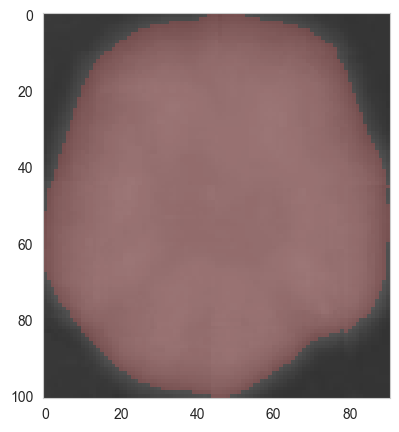

In [ ]:
color_measurements = MeasureColor().measure(pipeline_output)
color_measurements


In [ ]:
pipeline_measurements = kmarx_pipeline.measure(pipeline_output, include_metadata=False)
pipeline_measurements


,ObjectLabel,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,Bbox_MaxCC,Grid_RowNum,Grid_ColNum,Grid_SectionNum,...,TextureGray_HaralickVariance-avg-scale04,TextureGray_InverseDifferenceMoment-avg-scale04,TextureGray_SumAverage-avg-scale04,TextureGray_SumVariance-avg-scale04,TextureGray_SumEntropy-avg-scale04,TextureGray_Entropy-avg-scale04,TextureGray_DiffVariance-avg-scale04,TextureGray_DiffEntropy-avg-scale04,TextureGray_InfoCorrelation1-avg-scale04,TextureGray_InfoCorrelation2-avg-scale04
0,1,146.506703,170.569699,91,128,204,216,0,0,0,...,0.227501,0.917104,23.561500,0.725170,1.245760,1.447084,0.044131,0.675382,-0.292161,0.617447
1,2,149.396380,340.542659,97,298,204,386,0,1,1,...,0.738942,0.779646,25.834356,2.456797,2.475868,2.975292,0.028841,1.102396,-0.263979,0.763785
2,3,160.823387,503.184827,103,456,218,552,0,2,2,...,0.491629,0.844037,24.416443,1.642722,2.198116,2.531479,0.035992,0.916609,-0.294202,0.753914
3,4,163.507507,667.136392,105,616,224,720,0,3,3,...,1.169566,0.787356,27.764862,4.112562,2.690033,3.187108,0.026823,1.193745,-0.348834,0.855079
4,5,162.581936,988.687380,112,945,214,1035,0,5,5,...,1.006358,0.829287,26.639336,3.560625,2.155954,2.585183,0.032185,1.086397,-0.390953,0.841887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,1293.937771,489.301356,1239,448,1349,532,7,2,86,...,1.108200,0.742637,27.649365,3.755580,2.774204,3.409272,0.024679,1.263264,-0.269797,0.802120
86,87,1284.021505,1311.323189,1239,1275,1328,1350,7,7,91,...,1.370031,0.729467,27.969614,4.622844,2.764216,3.452672,0.021514,1.404993,-0.260746,0.795513
87,88,1298.299929,1475.423016,1250,1430,1348,1523,7,8,92,...,1.242901,0.774189,27.577465,4.450449,2.823792,3.349485,0.026872,1.125120,-0.352028,0.868454
88,89,1296.660489,1624.861193,1252,1582,1335,1670,7,9,93,...,1.464127,0.724083,27.086165,5.091357,2.989982,3.669252,0.023581,1.321775,-0.301962,0.848755
